# Core-valence separation


The influence of channel-restriction/CVS schemes for TDDFT can be considered for smaller systems by diagonalizing the full-space and CVS-space matrices, thus constructing the total global spectrum. This will not be possible for larger systems/basis sets, or for correlated method, where other [CVS relaxation schemes](https://doi.org/10.1063/5.0013538) have been used instead.

For a discussion of the underlying theory, see related sections, and here we primarily note that we will construct and resolve the RPA, obtaining transition energies as poles by solving the eigenvalue problem:
$$
E^{[2]}X = {\lambda} S^{[2]}X 
$$

where

$$
{\lambda} =\begin{pmatrix}
\lambda & 0\\
0 & -\lambda
\end{pmatrix}
$$

By rewriting the linear response equation, we obtain the oscillator strength as:

$$
(T^{\mu})^{2} = \sum_{\beta=x,y,z}{\mu_{\beta}^{[1]}}^\dagger X_n X_n^{\dagger}\mu_{\beta}^{[1]}\\
f_{osc}^{if} = \frac{2}{3}\cdot \omega_{if}\cdot(T^{\mu})^2
$$

This will now be done for water, where the ground state is calculated as:

In [3]:
import copy
import adcc
import matplotlib.pyplot as plt
import numpy as np
import veloxchem as vlx

def lorentzian(x, y, xmin, xmax, xstep, gamma):
    xi = np.arange(xmin, xmax, xstep)
    yi = np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)):
            yi[i] = yi[i] + y[k] * (gamma / 2.0) / (
                (xi[i] - x[k]) ** 2 + (gamma / 2.0) ** 2
            )
    return xi, yi

au2ev = 27.211386

In [4]:
water_mol_str = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

basis = "6-31G"
vlx_mol = vlx.Molecule.read_molecule_string(water_mol_str)
vlx_bas = vlx.MolecularBasis.read(vlx_mol, basis)

scf_drv = vlx.ScfRestrictedDriver()
scf_settings = {"conv_thresh": 1.0e-6}
method_settings = {"xcfun": "b3lyp"}
scf_drv.update_settings(scf_settings, method_settings)
scf_results = scf_drv.compute(vlx_mol, vlx_bas)

* Info * Reading basis set from file: /home/thomas/miniconda3/envs/echem/lib/python3.10/site-packages/veloxchem/basis/6-31G
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: 6-31G                                                                               
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
               

## Full-space results

For the full-space results, we construct the Hessian and property gradients:

In [5]:
lr_eig_solver = vlx.LinearResponseEigenSolver()
lr_eig_solver.update_settings(scf_settings, method_settings)

lr_solver = vlx.LinearResponseSolver()
lr_solver.update_settings(scf_settings, method_settings)

# Electronic Hessian
E2 = lr_eig_solver.get_e2(vlx_mol, vlx_bas, scf_results)

# Property gradients for dipole operator
V1_x, V1_y, V1_z = lr_solver.get_prop_grad("electric dipole", "xyz", vlx_mol, vlx_bas, scf_results)

# Dimension
c = int(len(E2) / 2)

# Overlap matrix
S2 = np.identity(2 * c)
S2[c : 2 * c, c : 2 * c] *= -1

* Info * Molecular grid with 40792 points generated in 0.04 sec.                                                          
                                                                                                                          
* Info * Processing Fock builds... (batch size: 160)                                                                      
* Info *   batch 1/1                                                                                                      


Calculating the excitation energies and oscillator strengths:

In [6]:
# Set up and solve eigenvalue problem
Sinv = np.linalg.inv(S2)  # for clarity - is identical
M = np.matmul(Sinv, E2)
eigs, X = np.linalg.eig(M)

# Reorder results
idx = np.argsort(eigs)
eigs = np.array(eigs)[idx]
X = np.array(X)[:, idx]

# Compute oscillator strengths
fosc = []
for i in range(int(len(eigs) / 2)):
    j = i + int(len(eigs) / 2)  # focus on excitations
    Xf = X[:, j]
    Xf = Xf / np.sqrt(np.matmul(Xf.T, np.matmul(S2, Xf)))
    tm = np.dot(Xf, V1_x) ** 2 + np.dot(Xf, V1_y) ** 2 + np.dot(Xf, V1_z) ** 2
    fosc.append(tm * 2.0 / 3.0 * eigs[j])

## CVS-space results

The dimensions of the CVS-space:

In [7]:
# Number of virtuals
nocc = vlx_mol.number_of_alpha_electrons()
nvirt = vlx.MolecularBasis.get_dimensions_of_basis(vlx_bas, vlx_mol) - nocc
n = nocc * nvirt

# CVS space
res_mo = 1
res_indx = 0
c = res_mo * nvirt

Hessian and property gradients:

In [8]:
## Construct CVS objects

# Define starting index for deexcitation
c_int_deex = n + res_indx

# CVS Hessian
E2_cvs = np.zeros((2 * c, 2 * c))
E2_cvs[0:c, 0:c] = E2[res_indx:c, res_indx:c]
E2_cvs[0:c, c : 2 * c] = E2[res_indx:c, c_int_deex : c_int_deex + c]
E2_cvs[c : 2 * c, 0:c] = E2[c_int_deex : c_int_deex + c, res_indx:c]
E2_cvs[c : 2 * c, c : 2 * c] = E2[
    c_int_deex : c_int_deex + c, c_int_deex : c_int_deex + c
]

# CVS overlap matrix
S2_cvs = np.identity(2 * c)
S2_cvs[c : 2 * c, c : 2 * c] *= -1

# CVS property gradients
V1_cvs_x = np.zeros(2 * c)
V1_cvs_x[0:c] = V1_x[res_indx:c]
V1_cvs_x[c : 2 * c] = V1_x[c_int_deex : c_int_deex + c]
V1_cvs_y = np.zeros(2 * c)
V1_cvs_y[0:c] = V1_y[res_indx:c]
V1_cvs_y[c : 2 * c] = V1_y[c_int_deex : c_int_deex + c]
V1_cvs_z = np.zeros(2 * c)
V1_cvs_z[0:c] = V1_z[res_indx:c]
V1_cvs_z[c : 2 * c] = V1_z[c_int_deex : c_int_deex + c]

Calculating energies and intensities:

In [9]:
# Set up and solve eigenvalue problem
Sinv = np.linalg.inv(S2_cvs)  # for clarity - is identical
M = np.matmul(Sinv, E2_cvs)
eigs_cvs, X_cvs = np.linalg.eig(M)

# Reorder results
idx = np.argsort(eigs_cvs)
eigs_cvs = np.array(eigs_cvs)[idx]
X_cvs = np.array(X_cvs)[:, idx]

# Compute oscillator strengths
fosc_cvs = []
for i in range(int(len(eigs_cvs) / 2)):
    j = i + int(len(eigs_cvs) / 2)  # focus on excitations
    Xf_cvs = X_cvs[:, j]
    Xf_cvs = Xf_cvs / np.sqrt(np.matmul(Xf_cvs.T, np.matmul(S2_cvs, Xf_cvs)))
    tm_cvs = (
        np.dot(Xf_cvs, V1_cvs_x) ** 2
        + np.dot(Xf_cvs, V1_cvs_y) ** 2
        + np.dot(Xf_cvs, V1_cvs_z) ** 2
    )
    fosc_cvs.append(tm_cvs * 2.0 / 3.0 * eigs_cvs[j])

### CVS-space results from VeloxChem

The CVS-space approach is implemented in VeloxChem and can be done by the ``LinearResponseEigenSolver`` class. To run CVS calculation, set ``core_excitation`` to True and ``num_core_orbitals`` to the number of core orbitals to be included.

In this example we only need to include one core orbital (O1s in water molecule).

In [10]:
lr_eig_solver.core_excitation = True
lr_eig_solver.num_core_orbitals = 1
lr_eig_solver.nstates = 3
vlx_cvs_results = lr_eig_solver.compute(vlx_mol, vlx_bas, scf_results)

                                                                                                                          
                                                                                                                          
                                            Linear Response EigenSolver Setup                                             
                                                                                                                          
                               Number of States                : 3                                                        
                               Max. Number of Iterations       : 150                                                      
                               Convergence Threshold           : 1.0e-06                                                  
                               ERI Screening Scheme            : Cauchy Schwarz + Density                                 
                

## Comparison

Comparing the obtained spectra:

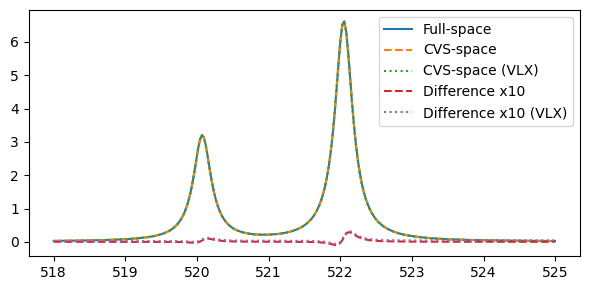

In [11]:
plt.figure(figsize=(6,3))

x, y = eigs[int(len(eigs) / 2) :], fosc
x1, y1 = lorentzian(x, y, 518 / au2ev, 525 / au2ev, 0.001, 0.3 / au2ev)
plt.plot(x1 * au2ev, y1)

x, y = eigs_cvs[int(len(eigs_cvs) / 2) :], fosc_cvs
x2, y2 = lorentzian(x, y, 518 / au2ev, 525 / au2ev, 0.001, 0.3 / au2ev)
plt.plot(x2 * au2ev, y2, linestyle='--')

x, y = vlx_cvs_results['eigenvalues'], vlx_cvs_results['oscillator_strengths']
x3, y3 = lorentzian(x, y, 518 / au2ev, 525 / au2ev, 0.001, 0.3 / au2ev)
plt.plot(x3 * au2ev, y3, linestyle=':')

plt.plot(x1 * au2ev, 10*(y1 - y2), linestyle='--')
plt.plot(x1 * au2ev, 10*(y1 - y3), linestyle=':')

plt.legend(("Full-space", "CVS-space", "CVS-space (VLX)", "Difference x10", "Difference x10 (VLX)"))
plt.tight_layout()
plt.show()